In [1]:
# To start this notebook with more than one thread, change the extension setting in vs, search for thread,
# and change the Max Threads as well as settings.json.
# This will speed up the computations for running multiple chains. 

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())
nr_chains = 4 # number of chains to sample, corresponding to the threads
results_dir = "results_section_6_1_Gibbs_10^4"

4


"results_section_6_1_Gibbs_10^4"

In [2]:
# using Pkg
# Pkg.add("Turing")
using Plots # to plot things
using Random, Distributions # generate random noise
using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 

using QuadGK
using BasicBSpline
using LaTeXStrings

using Optim # for ML and MAP estimation 

# Pkg.add("AdaptiveMCMC")
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 

using Printf  # Import Printf for formatted output
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using SparseArrays

include("../src/Mesh_fun.jl")
include("../src/FE_fun.jl")
include("../src/SIACMatrix.jl")

PostProcess (generic function with 1 method)

# Problem setup

In [3]:
# define test function
# testFun(x)=@. 2*x*sin(pi*x)
testFun(x)=@. sin(2*pi*x)+0.5*cos(4pi*x)^2 + 0.5

# define parameters
N = 100 # number of points

# generate true physical data on the uniform grid
xx = collect(LinRange(0,1,N))
fx = testFun(xx)

# variance of the iid Gaussian noise added to the measurements
σ² = 0.05

# forward operator, noise, and noisy data
# forward operator -- use the identity matrix for now
F = Matrix(1.0I, N, N)  # Identity matrix of Float64 type
Random.seed!(123) # Setting the seed
noise = rand( Normal(0,sqrt(σ²)), N )
fx_noisy = F * fx + noise

# SIAC matrix
# Piecewise Polynomial Setup for SIAC Filter
p = 3
# Create SIAC Matrix, with periodic boundary treatment
Ffil = global_SIAC_Mat(p, xx, boundaryTreatment="periodic")
# filtered noisy data
fx_noisy_filter = Ffil*fx_noisy

100-element Vector{Float64}:
 1.0254291208625161
 1.0268663337405446
 1.0227281782144504
 1.0237599058425901
 1.033618676455094
 1.0507365397560984
 1.0704652600331472
 1.0964250236281532
 1.1255150010132067
 1.1499535228277629
 ⋮
 0.2557035377952046
 0.32889114284593607
 0.39858678489446414
 0.4782188471310769
 0.5764140429354622
 0.6949851812050467
 0.8203580155918291
 0.9260039944511835
 0.9957298870854775

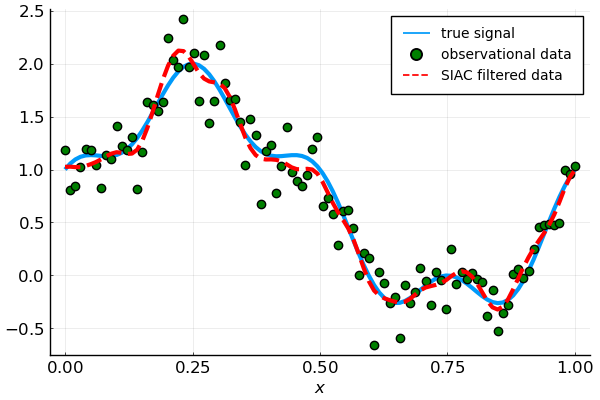

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_1_Gibbs_10^4/data.png"

In [4]:
# Plot underlying true function, noisy data, and filtered data
pyplot() 
# Create the plot for the underlying true function
plot_fx = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add noisy data  
Plots.scatter!(plot_fx, 
    xx, fx_noisy; 
    label="observational data", 
    markercolor = :green, markersize = 6, marker_alpha = 0.6 
)
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Make some cosmetic changes to the plot 
Plots.plot!( plot_fx,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_fx)
# Save the plot
savefig(plot_fx, joinpath(results_dir, "data.png"))  # Save as PNG

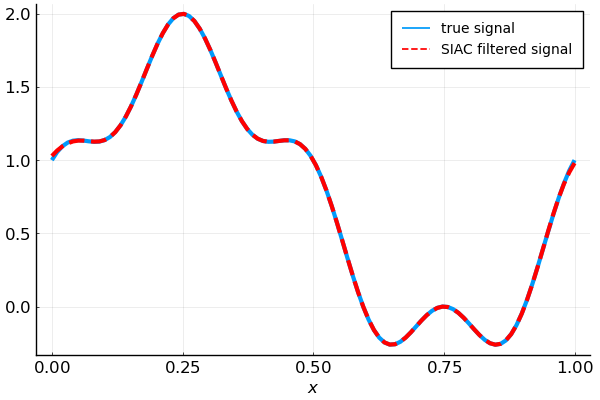

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_1_Gibbs_10^4/true_signal.png"

In [5]:
# Check SIAC filter applied on the underlying true function
# filtered data
fx_filter = Ffil*fx

pyplot() 
# Create the plot for the underlying true function
plot_fx_check = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_check, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered data 
Plots.plot!(plot_fx_check, 
    xx, fx_filter;     
    label="SIAC filtered signal",
    lw=3, ls=:dash, lc=:red 
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_check,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_fx_check)
# Save the plot
savefig(plot_fx_check, joinpath(results_dir, "true_signal.png"))  # Save as PNG

# Statistical model setup

We consider the following model: 
\begin{align*}
    \mathbf{fx\_noisy} & \sim \mathcal{N}(F\mathbf{u},\sigma^2*I) = \mathcal{N}(F\mathbf{u},\alpha^{-1}*I), \\
    R \mathbf{u} & \sim \mathcal{N}(\mathbf{0},\beta^{-1}*I), \\ 
\end{align*}
where $R$ is the regularization operator. 
The associated posterior log PDF is 
$$            
                -\frac{\alpha}{2}  \| F\mathbf{u} - \mathbf{fx\_noisy} \|_2^2 
                -\frac{\beta}{2}  \| R\mathbf{u} \|_2^2 
                - d \alpha - d\beta + (\frac{N}{2}+c-1)\log \alpha + (\frac{N}{2}+c-1)\log \beta.
$$

In [6]:
# Set up the statistical model

# regularization operator
R = Matrix(1.0I, N, N) - Ffil

c = 1
d = 1.0e-3
# Define the posterior log-PDF for both unknown signal and hyperparameters  
function logpdf_posterior(u, α, β) 
    if α<=0 || β<=0
        logpdf = -Inf
    else
        logpdf = -(.5α)*norm(F*u-fx_noisy)^2 -(.5β)*norm(R*u)^2 - d*α - d*β + (N/2+c-1)*log(α) + (N/2+c-1)*log(β)
    end
        
    return logpdf
end

# Define the log-PDF by grouping all the parameters
logpdf(z) = logpdf_posterior(z[1:end-2], z[end-1], z[end])
# Define the negative log-PDF
neg_logpdf(z) = -logpdf(z)

neg_logpdf (generic function with 1 method)

# MAP estimate

We will compare the MAP estimates obtained from the built-in optimizer (limited-memory Broyden–Fletcher–Goldfarb–Shanno L-BFGS algorithm) and the Block Coordinate Descent (BCD) algorithm.

## L-BFGS

In [7]:
# Obtain MAP estimate using built-in optimizer L-BFGS

# Initial guess for the optimization (u, α and β)
initial_guess = vcat(zeros(N), 1.0, 1.0)

tLBFGS = @elapsed begin # execution time    
    # MAP estimation
    map_estimate = optimize(neg_logpdf, initial_guess, LBFGS())
end
    
# Extract the MAP estimate of u
fx_LBFGS_tmp = Optim.minimizer(map_estimate)
fx_LBFGS = fx_LBFGS_tmp[1:end-2]

100-element Vector{Float64}:
 0.9896662196544338
 1.0249455498945579
 1.049657113795034
 1.0652611057584773
 1.073085928329253
 1.0753323697550539
 1.0738892489942902
 1.072262701863015
 1.0732125736976978
 1.0794126791214276
 ⋮
 0.20685553194027634
 0.3172180095090052
 0.4278237669226416
 0.5355547516351646
 0.6369500691674088
 0.7298833435522877
 0.8125649725983322
 0.8837274592127752
 0.9426377931682263

## BCD

In [8]:
# set up BCD function
using SparseArrays

function BCD_1d_scalar(F, y, R, c, d, QUIET)

    t_start = time()  # Measure time

    # Global constants and defaults
    MIN_ITER = 0
    MAX_ITER = 1000
    ABSTOL = 1e-8
    RELTOL = 1e-4

    # Data preprocessing
    m, n = size(F)  # number of (indirect) measurements and pixels
    k = size(R, 1)  # number of outputs of the regularization operator
    FtF = sparse(F' * F)  # product corresponding to the forward operator
    Fty = F' * y  # forward operator applied to the indirect data

    # Initial values for the inverse variances and the mean and others
    aalpha = 0.1
    bbeta = 1
    mu = zeros(n)
    mu_OLD = zeros(n)  # mean

    C_inv = Matrix(1.0I, n, n)

    abs_error = 0
    rel_error = 0

    if !QUIET
        println("iter\t abs error\t abs tol\t rel error\t rel tol")
    end

    # Iterate between the update steps until convergence or max number of iterations
    for counter in 1:MAX_ITER

        # 1) Fix aalpha, bbeta, and update x
        C_inv = sparse(aalpha * FtF + bbeta * R' * R)  # update covariance matrix
        mu = C_inv \ (aalpha * Fty)  # update the mean

        # 2) Fix x, B and update aalpha
        aalpha = (m + 2 * c) / (norm(F * mu - y)^2 + 2 * d)

        # 3) Fix x, aalpha and update B
        bbeta = (n + 2 * c) / (norm(R * mu)^2 + 2 * d)

        # Store certain values in history structure
        abs_error = norm(mu - mu_OLD)^2  # absolute error
        rel_error = (norm(mu - mu_OLD) / norm(mu_OLD))^2  # relative error

        mu_OLD = mu  # store value of mu

        if !QUIET
            println("$(counter)\t $(abs_error)\t $(ABSTOL)\t $(rel_error)\t $(RELTOL)")
        end

        # Check for convergence
        if abs_error < ABSTOL && rel_error < RELTOL && counter > MIN_ITER
            break
        end

    end

    # Output the time it took to perform all operations
    if !QUIET
        println("Elapsed time: ", time() - t_start, " seconds")
    end

    return mu, C_inv, aalpha, bbeta, Dict("abs_error" => abs_error, "rel_error" => rel_error)
end

BCD_1d_scalar (generic function with 1 method)

In [9]:
# Obtain MAP estimate using BCD algorithm
tBCD = @elapsed begin # execution time

    fx_BCD, C_inv, aalpha, bbeta, history = BCD_1d_scalar(F, fx_noisy, R, c, d, false ); 
    
end

iter	 abs error	 abs tol	 rel error	 rel tol
1	 108.01713463921439	 1.0e-8	 Inf	 0.0001
2	 0.1008690037317874	 1.0e-8	 0.0009338241017843853	 0.0001
3	 0.06835619187844917	 1.0e-8	 0.0006342583531601523	 0.0001
4	 0.0034393450745363874	 1.0e-8	 3.195162123908988e-5	 0.0001
5	 4.167835195122321e-6	 1.0e-8	 3.872637420001169e-8	 0.0001
6	 2.8338742803050538e-9	 1.0e-8	 2.6331746901783367e-11	 0.0001
Elapsed time: 0.0680999755859375 seconds


2.296511

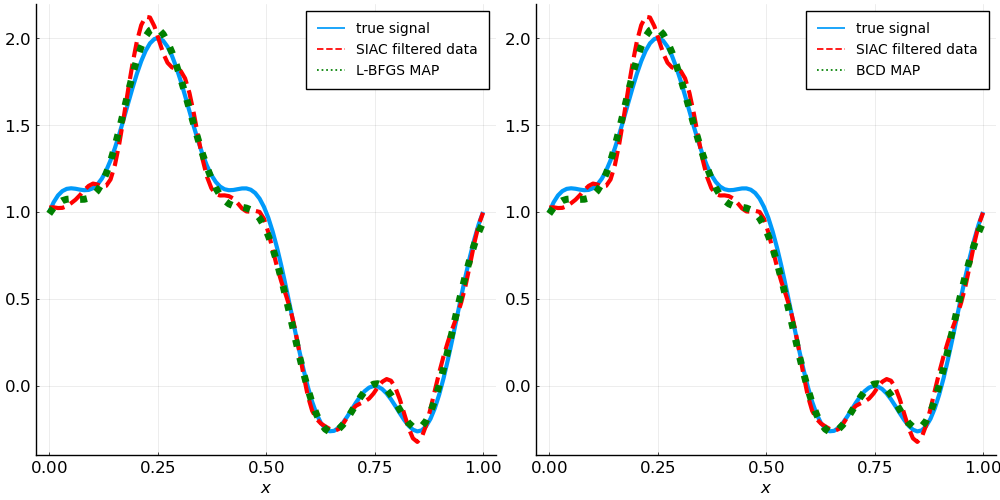

In [10]:
# Plot underlying true function, noisy data, and MAP estimates
pyplot() 
# Create the plot for the underlying true function
plot_fx_MAP1 = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_MAP1, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx_MAP1, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Add MAP estimate from built-in optimizer
Plots.plot!(plot_fx_MAP1, 
    xx, fx_LBFGS;     
    label="L-BFGS MAP",
    lw=5, ls=:dot, lc=:green
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_MAP1,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)

# Create the plot for the underlying true function
plot_fx_MAP2 = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# # Add noisy data  
# Plots.scatter!(plot_fx_MAP2, 
#     xx, fx_noisy; 
#     label="observational data", 
#     markercolor = :red, markersize = 6, marker_alpha = 0.6 
# )
# Add SIAC filtered noisy data 
Plots.plot!(plot_fx_MAP2, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# Add MAP estimate from BCD algorithm
Plots.plot!(plot_fx_MAP2, 
    xx, fx_BCD;     
    label="BCD MAP",
    lw=5, ls=:dot, lc=:green
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_fx_MAP2,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Combine the plots
plot_MAPs = Plots.plot(plot_fx_MAP1, plot_fx_MAP2, layout=(1, 2), size = (1000,500))
# Save the plot
savefig(plot_fx_MAP1, joinpath(results_dir, "MAP_LBFGS.png"))  # Save as PNG
savefig(plot_fx_MAP2, joinpath(results_dir, "MAP_BCD.png"))  # Save as PNG
# Display the plot
display(plot_MAPs)

In [11]:
# Compare the execution times for MAP estimates
println(@sprintf("Time for MAP estimate with LBFGS: %-15.4f seconds", tLBFGS))
println(@sprintf("Time for MAP estimate with BCD:   %-15.4f seconds", tBCD))

# Compute relative L2 errors
rel_l2_err_LBFGS = norm(fx_LBFGS - fx) / norm(fx)
rel_l2_err_BCD = norm(fx_BCD - fx) / norm(fx)

# Compare relative L2 errors
println(@sprintf("Relative l2 error for MAP estimate with LBFGS: %-15.4e", rel_l2_err_LBFGS))
println(@sprintf("Relative l2 error for MAP estimate with BCD:   %-15.4e", rel_l2_err_BCD))


Time for MAP estimate with LBFGS: 2.8576          seconds
Time for MAP estimate with BCD:   2.2965          seconds
Relative l2 error for MAP estimate with LBFGS: 4.8448e-02     
Relative l2 error for MAP estimate with BCD:   4.8457e-02     


# Sampling

We will compare the performance of Gibbs sampling and AM sampling. Here we do Gibbs sampling.

## Generate random initializations

In [12]:
## Genrate random samples from the original prior 

# Set-up an array for the initializations 
initial_random = Array{Float64}(undef, N+2, nr_chains)

# Generate α- and β-samples from the gamma distribution
α_random = rand(Gamma(c, 1/d), nr_chains)
β_random = rand(Gamma(c, 1/d), nr_chains)

# Get corresponding u-sample by performing an x-update 
u_random = Array{Float64}(undef, N, nr_chains)
for j in 1:nr_chains
    α = α_random[j]
    β = β_random[j]
    C_inv = sparse(α*F'*F + β*R'*R)  # update covariance matrix
    u_random[:,j] = C_inv \ (α*F'*fx_noisy)  # update the mean
end

# Collect the α-, β-, and u-samples
for j in 1:nr_chains
    initial_random[1:end-2,j] .= u_random[:,j]
    initial_random[end-1,j] = α_random[j]
    initial_random[end,j] = β_random[j]
end

In [13]:
# Initialization option: "MAP", "random"
init = "random" 

# Choose an initialization for the MCMC chains 
init_param = Array{Float64}(undef, N+2, nr_chains)

# Use MAP estimate 
if init=="MAP"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param[:,j] = fx_MAP_tmp
    end

# Use random initializations 
elseif init=="random"
    init_param = initial_random

# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'random'.")
end

102×4 Matrix{Float64}:
    0.984005    1.09664      1.10148      1.15873
    1.02001     0.914666     0.90815      0.832479
    1.04646     0.935891     0.930583     0.870039
    1.0645      1.01832      1.01876      1.02463
    1.075       1.10329      1.10879      1.17331
    1.07979     1.10827      1.11295      1.16755
    1.07992     1.04753      1.04701      1.04136
    1.07906     0.964177     0.95599      0.860842
    1.07957     1.13545      1.13545      1.13828
    1.08387     1.1421       1.13991      1.11203
    ⋮                                  
    0.432926    0.435288     0.43741      0.464405
    0.539259    0.48604      0.485803     0.486551
    0.638543    0.532967     0.529498     0.491924
    0.729172    0.603808     0.597638     0.525446
    0.809787    0.908946     0.914257     0.976029
    0.879208    0.941416     0.943008     0.957099
    0.937053    1.01155      1.01312      1.02845
    3.06675   188.036     1174.33      1582.06
 3585.16      206.361     1144.

## Gibbs sampling

In [14]:
# Define the Gibbs sampling function
function gibbs_sampler(init, y, F, R, c, d, iterations)
    N = size(F, 2)  # Number of elements in u
    m = size(y, 1)  # Length of observed data y

    Ft = transpose(F)
    Rt = transpose(R)
    FtF = Ft*F
    RtR = Rt*R
    Fty = Ft*y

    # Initialize latent variables and parameters
    u = init[1:end-2]  # Initial guess for u
    α = init[end-1]  # Initial guess for alpha from Gamma prior
    β = init[end]  # Initial guess for beta from Gamma prior

    # Preallocate space to store samples
    samples_u = zeros(N, iterations)
    samples_α = zeros(iterations)
    samples_β = zeros(iterations)

    for i in 1:iterations
        # Step 1: Sample u | y, α, β
        # Σ_u_inv = α * (F' * F) + β * (R' * R)  # Posterior precision
        # Σ_u = inv(Σ_u_inv)  # Posterior covariance
        # Σ_u = 0.5*(Σ_u + Σ_u')
        # μ_u = Σ_u * (α * F' * y)  # Posterior mean of u
        # u = rand(MvNormal(μ_u, Σ_u))  # Sample u from conditional posterior
        v1 = randn(m)
        v2 = randn(N)
        w = sqrt(α)*Ft*v1 + sqrt(β)*Rt*v2
        C = α*FtF + β*RtR
        rhs = α*Fty + w
        u = C \ rhs

        # Step 2: Sample α | u, y
        residuals_y = y - F * u
        shape_α = c + m / 2  # Posterior shape for Gamma
        rate_α = d + sum(residuals_y.^2) / 2  # Posterior rate for Gamma
        α = rand(Gamma(shape_α, 1 / rate_α))  # Sample α

        # Step 3: Sample β | u, Ru
        residuals_Ru = R * u
        shape_β = c + N / 2  # Posterior shape for Gamma
        rate_β = d + sum(residuals_Ru.^2) / 2  # Posterior rate for Gamma
        β = rand(Gamma(shape_β, 1 / rate_β))  # Sample β

        # Store samples
        samples_u[:, i] = u
        samples_α[i] = α
        samples_β[i] = β
    end

    return samples_u', samples_α', samples_β'
end

gibbs_sampler (generic function with 1 method)

In [15]:
# Number of Gibbs iterations
G_iterations = 10^4

# Number of parameters
nr_params_Gibbs = N + 2

burn_in= Int64(ceil(G_iterations/10))

G_samples_aux = zeros(Float64, G_iterations+burn_in, nr_params_Gibbs, nr_chains)
G_samples = zeros(Float64, G_iterations, nr_params_Gibbs, nr_chains)

# Run the Gibbs sampler
Random.seed!(123) # Setting the seed
# G_samples_u, G_samples_α, G_samples_β = gibbs_sampler(fx_noisy, F, R, c, d, G_iterations)

# Start the wall clock timer
wall_start = now()
t_start = time()

# Use multiple threads 
@showprogress Threads.@threads for j in 1:nr_chains
    G_samples_aux[:,1:end-2,j], G_samples_aux[:,end-1,j], G_samples_aux[:,end,j] = gibbs_sampler(init_param[:,j], fx_noisy, F, R, c, d, G_iterations+burn_in)
    G_samples[:,:,j] = G_samples_aux[burn_in+1:end,:,j]
end


# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
t_time = time() - t_start
# Convert wall duration to seconds
G_wall_duration = Dates.value(wall_duration_ms) / 1000

# Display the results
println("Gibbs sampling completed.")
print(t_time)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Gibbs sampling completed.
4.560451984405518

In [16]:
# Construct MCMC chains 

# Define the parameter names 
G_param_names = ["u[$i]" for i in 1:N+2]
G_param_names[end-1] = "α"
G_param_names[end] = "β"

# Create the chains object
G_chn = Chains(G_samples, Symbol.(G_param_names))

Chains MCMC chain (10000×102×4 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 4
Samples per chain = 10000
parameters        = u[1], u[2], u[3], u[4], u[5], u[6], u[7], u[8], u[9], u[10], u[11], u[12], u[13], u[14], u[15], u[16], u[17], u[18], u[19], u[20], u[21], u[22], u[23], u[24], u[25], u[26], u[27], u[28], u[29], u[30], u[31], u[32], u[33], u[34], u[35], u[36], u[37], u[38], u[39], u[40], u[41], u[42], u[43], u[44], u[45], u[46], u[47], u[48], u[49], u[50], u[51], u[52], u[53], u[54], u[55], u[56], u[57], u[58], u[59], u[60], u[61], u[62], u[63], u[64], u[65], u[66], u[67], u[68], u[69], u[70], u[71], u[72], u[73], u[74], u[75], u[76], u[77], u[78], u[79], u[80], u[81], u[82], u[83], u[84], u[85], u[86], u[87], u[88], u[89], u[90], u[91], u[92], u[93], u[94], u[95], u[96], u[97], u[98], u[99], u[100], α, β

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Floa

### Traces for a specific location

We focus on investigating  $(u[j],\alpha,\beta)$ for $j=50$.
Note that $t[j] \approx 0.5$ and $u_{\rm true}[j] \approx 0.52$ for $j=50$.

In [17]:
 # Extract sample values 
j = 50 

# Get the u-samples
G_u_j = get(G_chn, :u).u[j]
# Get the α-samples
G_α = get(G_chn, :α).α
# Get the β-samples
G_β = get(G_chn, :β).β

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:10000
    :chain, 1:4
And data, a 10000×4 Matrix{Float64}:
 4778.2    5017.58   6057.04   3882.18
 4386.77   3598.95   7251.17   3757.18
 4710.08   4695.86   8867.83   5079.82
 5024.59   4793.42   7636.45   5253.03
 4572.75   4128.73  10873.9    4011.14
 4534.62   5897.48   9674.02   4126.41
 5136.4    6980.6   10961.9    3955.47
 4780.89   9033.04  11580.5    3941.81
 3526.07   7964.02  12083.8    5822.45
 3553.84   7840.79   7375.95   5667.06
    ⋮                         
 8088.76   7253.92  12232.9   10418.2
 9031.12   6489.54  10963.0   10473.4
 6260.78   5961.78   9705.76   9253.45
 5402.97   9536.66  10514.8   13280.9
 4931.18  10477.1   10651.5   11422.4
 4931.83   7178.64  10121.5    8547.96
 4609.07   7105.45  14944.7    8604.09
 4358.09   7651.27  10430.3    9332.45
 4875.71   7121.5   10163.0    9295.6

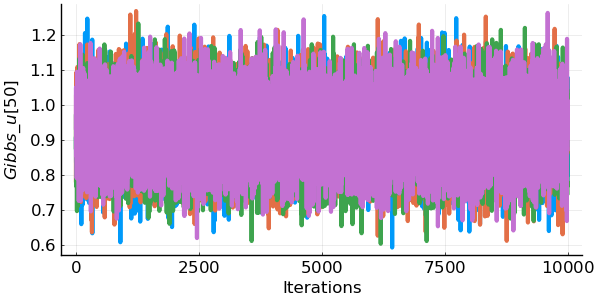

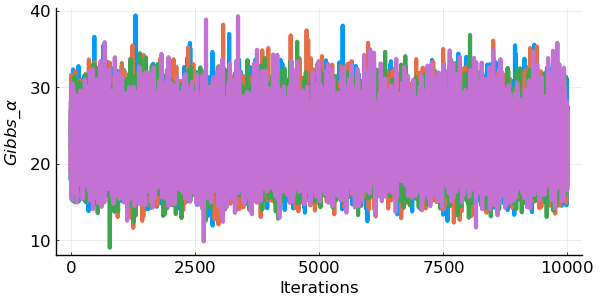

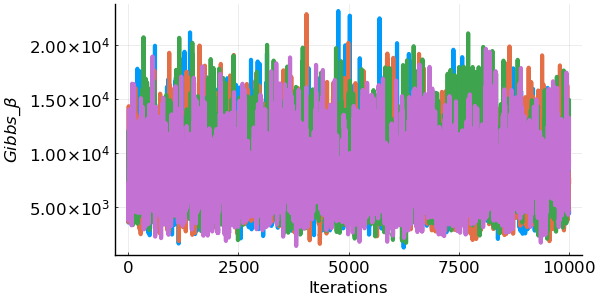

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_1_Gibbs_10^4/chain_Gibbs_beta.png"

In [18]:
# Generate figure
Plots.pyplot()
# Create the traceplot
p_Gibbs_u = StatsPlots.plot(
    G_u_j, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"Gibbs\_u[50]",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_Gibbs_u)
# Save the plot
savefig(p_Gibbs_u, joinpath(results_dir, "chain_Gibbs_u50.png"))  # Save as PNG

# Generate figure
Plots.pyplot()
# Create the traceplot
p_Gibbs_alpha = StatsPlots.plot(
    G_α, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"Gibbs\_α",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_Gibbs_alpha)
# Save the plot
savefig(p_Gibbs_alpha, joinpath(results_dir, "chain_Gibbs_alpha.png"))  # Save as PNG

# Create the traceplot
p_Gibbs_beta = StatsPlots.plot(
    G_β, 
    lw=3, 
    legend=false, 
    xlabel="Iterations", ylabel=L"Gibbs\_β",
    tickfontsize=12, labelfontsize=12, legendfontsize=12, 
    size=(600,300)
)
# Display the plot
display(p_Gibbs_beta)
# Save the plot
savefig(p_Gibbs_beta, joinpath(results_dir, "chain_Gibbs_beta.png"))  # Save as PNG

### Multivariate potential scale reduction factor (MPSRF)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


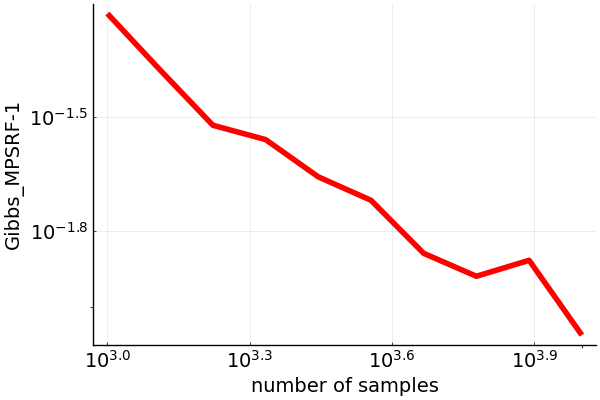

The last value of the MPSRF is
1.0084366010602286

In [19]:
# Compute the MPSRF versus number of samples 
num_points = 10  # Number of equidistant points
nr_aux = length(G_chn[:, 1, 1])
increments = Int.( ceil.( maprange(log, 10^3, nr_aux, length=num_points) ))
# maprange function in pkg FlexiMaps

# Array to store MPSRF values
Gibbs_MPSRF_values = Float64[]

# Compute MPSRF for each subset of the chain
@showprogress for n in increments 
    Gibbs_MPSRF = gelmandiag_multivariate(G_chn[1:n, :, :] )
    push!(Gibbs_MPSRF_values, Gibbs_MPSRF[2])
end

# Generate figure
Plots.pyplot()

# Set tick locations and labels
xticks = [10^1, 10^2, 10^3, 10^4, 10^5, 10^6]
yticks = [10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2)]

# Create the plot 
plot_Gibbs_MPSRF = plot(increments, Gibbs_MPSRF_values.-1; 
    lw=4, ls=:solid, color = :red )

# Make some cosmetic changes to the plot 
plot!(plot_Gibbs_MPSRF, 
    xscale=:log10, yscale=:log10, # log scale for x-axis and labels
    xlabel="number of samples", ylabel="Gibbs_MPSRF-1", # labels 
    tickfontsize=14, labelfontsize=14, legend=false,
    # xticks=xticks, yticks=yticks
)

# Display the plot
display(plot_Gibbs_MPSRF)
# Save the plot
savefig(plot_Gibbs_MPSRF, joinpath(results_dir, "MPSRF_Gibbs.png"))  # Save as PNG

println("The last value of the MPSRF is")
print(Gibbs_MPSRF_values[end])

In [20]:
display(Gibbs_MPSRF_values)

10-element Vector{Float64}:
 1.059108577254181
 1.0419802707303998
 1.030050563073126
 1.027562588442823
 1.0219932538494214
 1.0190831192051764
 1.0138394196403855
 1.012047130227738
 1.0132694480929365
 1.0084366010602286

### Effective sample size (ESS)

In [21]:
G_ESS = ess(G_chn)

# Assuming ESS_original is a DataFrame or similar structure
G_ess_values = G_ESS[:,2]  # Extract the 'ess' column

# Compute the minimum, maximum, mean, and median
@show G_min_ess = minimum(G_ess_values)
@show G_max_ess = maximum(G_ess_values)
@show G_mean_ess = mean(G_ess_values)
@show G_median_ess = median(G_ess_values)

# Wall duration to generate samples
@show G_wall_duration

# Compute the minimum, maximum, mean, and median per second 
@show G_min_ess_perSec = G_min_ess/G_wall_duration
@show G_max_ess_perSec = G_max_ess/G_wall_duration
@show G_mean_ess_perSec = G_mean_ess/G_wall_duration
@show G_median_ess_perSec = G_median_ess/G_wall_duration

G_min_ess = minimum(G_ess_values) = 3503.273644114277
G_max_ess = maximum(G_ess_values) = 40510.607928981066
G_mean_ess = mean(G_ess_values) = 38774.77322758562
G_median_ess = median(G_ess_values) = 39534.07104195007
G_wall_duration = 4.561
G_min_ess_perSec = G_min_ess / G_wall_duration = 768.0933225420472
G_max_ess_perSec = G_max_ess / G_wall_duration = 8881.957449897187
G_mean_ess_perSec = G_mean_ess / G_wall_duration = 8501.3754061797
G_median_ess_perSec = G_median_ess / G_wall_duration = 8667.851576836236


8667.851576836236

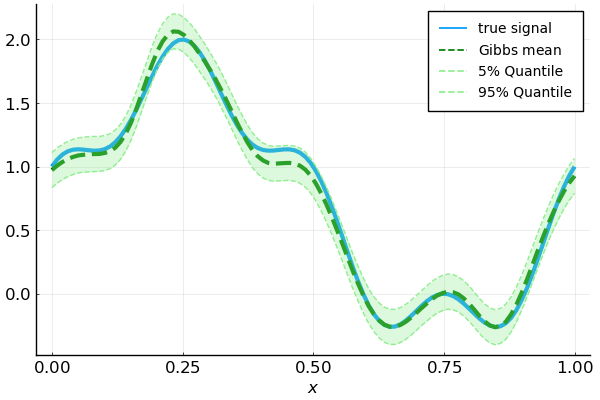

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_1_Gibbs_10^4/quantile_Gibbs.png"

In [22]:
# Compute the statistics from Gibbs sampling
# Extract the samples of u
G_u_samples = get(G_chn, :u).u

G_u_mean = [mean(G_u_samples[i]) for i in 1:N]
G_u_lower_quantile = [quantile(vec(G_u_samples[i]), 0.05) for i in 1:N]  # 5% quantile
G_u_upper_quantile = [quantile(vec(G_u_samples[i]), 0.95 ) for i in 1:N]  # 95% quantile

# Convert to vectors for plotting
G_u_lower_quantile = collect(G_u_lower_quantile)
G_u_upper_quantile = collect(G_u_upper_quantile)

pyplot() 
# Create the plot for the underlying true function
plot_Gibbs_var = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add Gibbs mean
Plots.plot!(plot_Gibbs_var, 
    xx, G_u_mean;
    label=L"\text{Gibbs mean}",
    lw=3, ls=:dash, lc=:green
)
# Add Gibbs quantile
Plots.plot!(plot_Gibbs_var, 
    xx, G_u_lower_quantile; 
    label="5% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add Gibbs quantile
Plots.plot!(plot_Gibbs_var, 
    xx, G_u_upper_quantile; 
    label="95% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add shaded region between the quantiles for x
Plots.plot!(plot_Gibbs_var,
    xx, G_u_lower_quantile, fillrange = G_u_upper_quantile, 
    label=false, fillalpha = 0.3, lw=0, color=:lightgreen
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_Gibbs_var,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_Gibbs_var)
# Save the plot
savefig(plot_Gibbs_var, joinpath(results_dir, "quantile_Gibbs.png"))  # Save as PNG



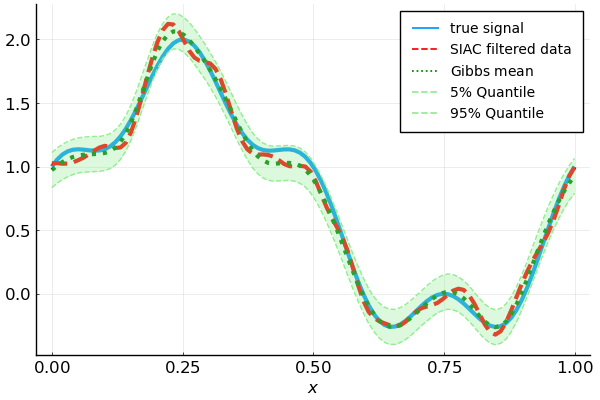

"/Users/tongtongli/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/notebooks/results_section_6_1_Gibbs_10^4/plot_add_Gibbs.png"

In [23]:
# additional plot including:  (i) the true signal, (ii) the SIAC-filtered data, (iii) the BCD MAP estimate, and (iv) the Gibbs mean + quantiles.
pyplot() 
# Create the plot for the underlying true function
plot_add = Plots.plot( 
    xx, fx; 
    label="true signal", lw=3, ls=:solid 
)
# Add SIAC filtered noisy data 
Plots.plot!(plot_add, 
    xx, fx_noisy_filter;     
    label="SIAC filtered data",
    lw=3, ls=:dash, lc=:red 
)
# # Add MAP estimate from BCD algorithm
# Plots.plot!(plot_add, 
#     xx, fx_BCD;     
#     label="BCD MAP",
#     lw=5, ls=:dot, lc=:green
# )
# Add Gibbs mean
Plots.plot!(plot_add, 
    xx, G_u_mean;
    label=L"\text{Gibbs mean}",
    lw=3, ls=:dot, lc=:green
)
# Add Gibbs quantile
Plots.plot!(plot_add, 
    xx, G_u_lower_quantile; 
    label="5% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add Gibbs quantile
Plots.plot!(plot_add, 
    xx, G_u_upper_quantile; 
    label="95% Quantile", lw=1, ls=:dash, color=:lightgreen
)
# Add shaded region between the quantiles for x
Plots.plot!(plot_add,
    xx, G_u_lower_quantile, fillrange = G_u_upper_quantile, 
    label=false, fillalpha = 0.3, lw=0, color=:lightgreen
)
# Make some cosmetic changes to the plot 
Plots.plot!(plot_add,
    xlabel=L"x",  
    tickfontsize=12, labelfontsize=12, legendfontsize=10 # font sizes 
)
# Display the plot
display(plot_add)
# Save the plot
savefig(plot_add, joinpath(results_dir, "plot_add_Gibbs.png"))  # Save as PNG
